# Quantum Teleportation with Qiskit
### Kamal Pangeni
Ref: https://qiskit.org/textbook/ch-algorithms/teleportation.html

In [1]:
# import required libraries
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

#### Review of Quantum Entanglement

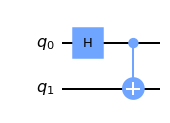

In [2]:
qc = QuantumCircuit(2)
# Apply H-gate to the first:
qc.h(0)
# Apply a CNOT:
qc.cx(0,1)
qc.draw('mpl')

$$
H|00\rangle=|0+\rangle = |0\rangle\tfrac{1}{\sqrt{2}}(|0\rangle+|1\rangle) = \tfrac{1}{\sqrt{2}}(|00\rangle+|01\rangle)
$$

$$
CNOT \tfrac{1}{\sqrt{2}}(|00\rangle+|01\rangle) = \tfrac{1}{\sqrt{2}}(|00\rangle+|11\rangle)
$$

In [3]:
# Let's see the result
backend = Aer.get_backend('statevector_simulator')

final_state = execute(qc,backend).result().get_statevector()
array_to_latex(final_state, pretext="\\text{Statevector} = ")

<IPython.core.display.Math object>

HW: Show that $ \tfrac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$ cannot be decomposed as tensor products of single qubits' states.

#### Basic Idea of Quantum Teleportation

Alice wants to send a qubit state $|\psi\rangle$ to Bob  
$$|\psi \rangle=a|0 \rangle+b|1\rangle$$

No-cloning Theorem $\Rightarrow$ One cannot simply make an exact copy of an unknown quantum state

By taking advantage of two classical bits and an entangled qubit pair, Alice can transfer her state  
$|\psi\rangle$ to Bob.

#### Steps involved in Quantum Teleportaion

* Step1: Create an entangled qubit pair,$|\phi\rangle$, from qubits $q_1$ and $q_2$
* Step2: Send one of the entangled qubit to Alice, say $q_1$, and the other one,$q_2$, to Bob.<br>
* Step3: Alice then performs certain operations on her qubit ($q_1$) with $\psi$ as control and measures both qubits. The result is then sent to Bob via classical channel.
* Step4: Based on the classical information, Bob performation certain operations to recover state $\psi$

#### Step 1

Let $\phi$ represent the entangled qubit pair. This can be acheived by applying a Hadamard gate followed by a CNOT gate.<br>
$$|\phi \rangle=\frac{1}{\sqrt 2}(|00\rangle+|11\rangle)$$

#### Step 2

Alice keeps the first qubit and Bob keeps the second one.

#### State of three qubit pair

Qubit state that Alice wants to send to Bob.$$|\psi \rangle = a|0\rangle+b|1\rangle$$

Three Qubit State: $$|\phi \rangle \times |\psi \rangle = \frac{1}{\sqrt 2}(|00\rangle+|11\rangle)\times (a|0\rangle+b|1\rangle)$$

$$\frac{1}{\sqrt 2}(a|000\rangle+b|001\rangle+a|110\rangle+b|111\rangle)$$

Remember, Alice has first two qubits and Bob has the 3rd qubit

#### Step 3

Alice Applies CNOT gate to $q_1$ (middle qubit in above representation), controlled by $q_0$ (rightmost qubit in above representation), followed by Hadamard gate to $q_0$.

CNOT$\frac{1}{\sqrt 2}(a|000\rangle+b|001\rangle+a|110\rangle+b|111\rangle)$ = $\frac{1}{\sqrt 2}(a|000\rangle+b|011\rangle+a|110\rangle+b|101\rangle)$

H$\frac{1}{\sqrt 2}(a|000\rangle+b|011\rangle+a|110\rangle+b|101\rangle)$ = $\frac{1}{\sqrt 2}(a|00+\rangle+b|01-\rangle+a|11+\rangle+b|10-\rangle)$

Remember, $$|+\rangle = \frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$$
          $$|-\rangle = \frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$$



This will result in:

$$\frac{1}{2}((a|0\rangle+b|1\rangle)|00\rangle\\+(a|0\rangle-b|1\rangle)|01\rangle\\+(a|1\rangle+b|0\rangle)|10\rangle\\+(a|1\rangle-b|0\rangle)|11\rangle)$$

Alice will measure the first two qubits. The result she will obtain will always be one of four standard basis states. $|00\rangle, 01\rangle, 10\rangle, 11\rangle$
This information is sent to Bob through classical channel.

#### Step 4

Upon receiving the information, Bob can recover state $|\psi\rangle$ by applying appropriate gates

00  → Do nothing

01  → Apply Z gate

10  → Apply X gate

11  → Apply ZX gate

https://www.nature.com/news/quantum-teleportation-is-even-weirder-than-you-think-1.22321

#### Quantum Teleportation Protocol

Create our Quantum Circuit

In [4]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [6]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

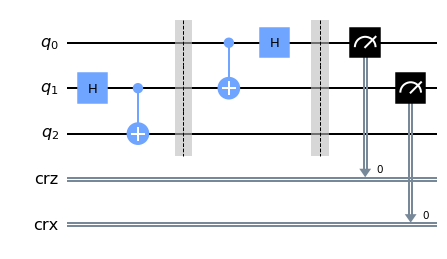

In [7]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

# STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw('mpl')

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw('mpl')

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw('mpl')

In [8]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

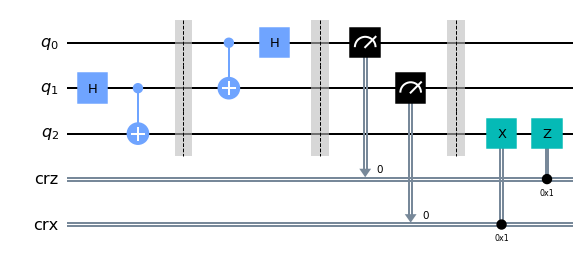

In [9]:
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw('mpl')

### Simulating the Teleportation protocol

<IPython.core.display.Math object>

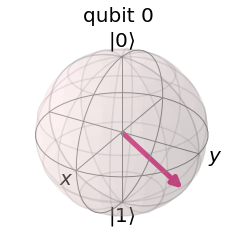

In [14]:
# Create random 1-qubit state
psi = random_state(1)

# Display it nicely
array_to_latex(psi, pretext="|\\psi\\rangle =")
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

In [15]:
init_gate = Initialize(psi)
init_gate.label = "init"

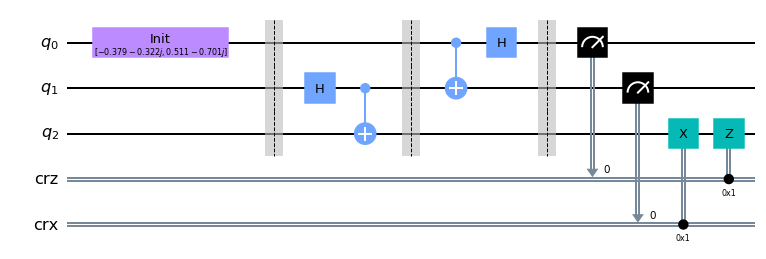

In [16]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw('mpl')

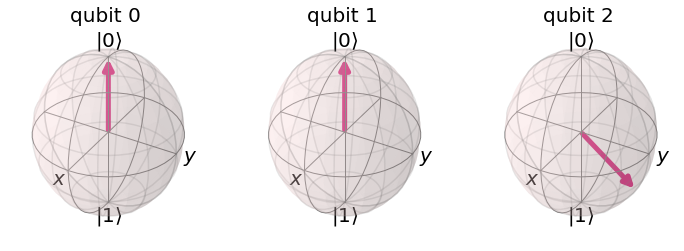

In [17]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
out_vector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(out_vector)

### Using the QASM Simulator

In [18]:
inverse_init_gate = init_gate.gates_to_uncompute()

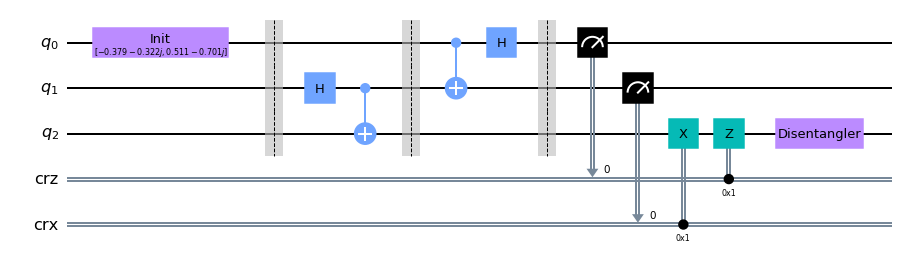

In [19]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw('mpl')

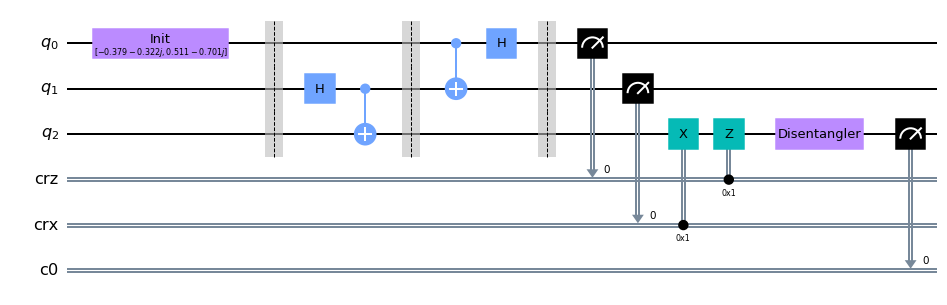

In [20]:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw('mpl')

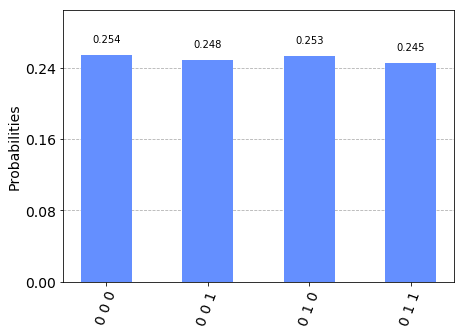

In [21]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
counts = qasm_sim.run(qobj).result().get_counts()
plot_histogram(counts)

### Teleportation on a Real Quantum Computer 

In [22]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

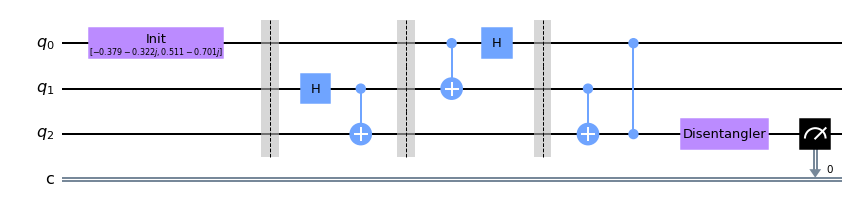

In [23]:
qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw('mpl')

In [24]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [25]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)
job_monitor(job)  # displays job status under cell

Job Status: job has successfully run


{'0': 880, '1': 144}


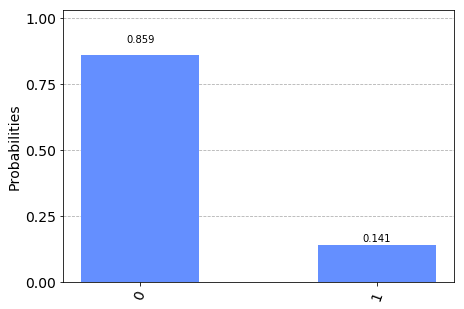

In [26]:
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)

In [27]:
print(f"The experimental error rate : {exp_counts['1']/sum(exp_counts.values()):.3f}%")

The experimental error rate : 0.141%
